In [1]:
import pandas as pd 
import numpy as np
import nltk
import re 
import os 
import string
import gensim
import matplotlib.pyplot as plt
import sys
import seaborn as sns
!pip3 install textblob

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud



In [2]:
data = pd.read_csv('covid19_tweets_06 Mar.csv')

In [3]:
data.head()

user_name            user_location  \
0  DuchessJani 🇪🇺🇵🇱🇬🇷🇩🇪🏴󠁧󠁢󠁷󠁬󠁳󠁿🇬🇧🇺🇦             England U.K.   
1                             Iran                     Iran   
2             #ThePeoplesSpeaker™️  Airwaves Across America   
3            Adam, Diabetic Cyborg             Longview, TX   
4                       Lady Susan            Great Britain   

                                    user_description  \
0  #Oil Painter #Artist @MAFAartists @RNCMlive @S...   
1  Twitter Page of The Iran Project Website, Non-...   
2  From the Halls of Justice, to the House of Rep...   
3  Muslim, Optimist, History/Poli. Sci. Prof. wit...   
4  Hobby; mto cards, Artist, Sewer, Mum of 4 boys...   

                user_created  user_followers  user_friends  user_favourites  \
0  2009-08-28 22:29:07+00:00             829           967            19752   
1  2007-03-25 15:14:45+00:00          168597            12             3367   
2  2009-03-26 15:34:24+00:00            9254          1793            44685   
3  2008-03-26 20:53:12+00:00            6700          4699            51228   
4  2010-10-07 17:26:42+00:00             157          1063             4260   

   user_verified                       date  \
0          False  2022-03-06 13:45:02+00:00   
1          False  2022-03-06 13:45:00+00:00   
2           True  2022-03-06 13:44:58+00:00   
3          False  2022-03-06 13:44:56+00:00   
4          False  2022-03-06 13:44:53+00:00   

                                                text  \
0  Help slow the spread of #COVID19 and identify ...   
1  COVID-19 kills 201 more Iranians over past 24 ...   
2  It’s Sunday, March 6, 2022 &amp; this is your ...   
3  Current #LongCOVID #Statistics Are Missing the...   
4  With news that @BootsUK is selling lateral flo...   

                      hashtags              source  is_retweet  
0                  ['COVID19']     Twitter Web App       False  
1   ['COVID19', 'coronavirus']           TweetDeck       False  
2                          NaN  Twitter for iPhone       False  
3  ['LongCOVID', 'Statistics']     Twitter Web App       False  
4                          NaN     Twitter Web App       False

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12452 entries, 0 to 12451
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         12452 non-null  object
 1   user_location     9433 non-null   object
 2   user_description  11230 non-null  object
 3   user_created      12452 non-null  object
 4   user_followers    12452 non-null  int64 
 5   user_friends      12452 non-null  int64 
 6   user_favourites   12452 non-null  int64 
 7   user_verified     12452 non-null  bool  
 8   date              12452 non-null  object
 9   text              12452 non-null  object
 10  hashtags          7139 non-null   object
 11  source            12452 non-null  object
 12  is_retweet        12452 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 1.1+ MB


In [5]:
data['is_retweet']
a=[]
b=[]
for i in data['is_retweet']:
    if i==True:
        a.append(i)
    else:
        b.append(i)
print(len(a))
print(len(b)) # all re-tweet is False, no need to remove any test row

0
12452


In [6]:
waste_col = ['user_name', 'user_location','user_description','user_created','user_followers','user_friends','user_favourites','date','source','hashtags',  'is_retweet','user_verified']

data = data.drop(waste_col, axis = 1)

In [7]:
data.head()

text
0  Help slow the spread of #COVID19 and identify ...
1  COVID-19 kills 201 more Iranians over past 24 ...
2  It’s Sunday, March 6, 2022 &amp; this is your ...
3  Current #LongCOVID #Statistics Are Missing the...
4  With news that @BootsUK is selling lateral flo...

# Preprocessing

Here are three main steps, one is to extract the tokens, the second is to use the same method to get the clean tweet data to use for sentiment analysis. The third is to implement sentiment analysis and statistic calculation

## 1. Extract the tokens

## Lowercase 

In [8]:
data['clean text'] = data.text.str.lower() 

In [9]:
data.head()

text  \
0  Help slow the spread of #COVID19 and identify ...   
1  COVID-19 kills 201 more Iranians over past 24 ...   
2  It’s Sunday, March 6, 2022 &amp; this is your ...   
3  Current #LongCOVID #Statistics Are Missing the...   
4  With news that @BootsUK is selling lateral flo...   

                                          clean text  
0  help slow the spread of #covid19 and identify ...  
1  covid-19 kills 201 more iranians over past 24 ...  
2  it’s sunday, march 6, 2022 &amp; this is your ...  
3  current #longcovid #statistics are missing the...  
4  with news that @bootsuk is selling lateral flo...

In [10]:
data.rename(columns = { 'clean text' : 'cleantext'}, inplace = True)

In [11]:
data.head()

text  \
0  Help slow the spread of #COVID19 and identify ...   
1  COVID-19 kills 201 more Iranians over past 24 ...   
2  It’s Sunday, March 6, 2022 &amp; this is your ...   
3  Current #LongCOVID #Statistics Are Missing the...   
4  With news that @BootsUK is selling lateral flo...   

                                           cleantext  
0  help slow the spread of #covid19 and identify ...  
1  covid-19 kills 201 more iranians over past 24 ...  
2  it’s sunday, march 6, 2022 &amp; this is your ...  
3  current #longcovid #statistics are missing the...  
4  with news that @bootsuk is selling lateral flo...

## Remove URL links

In [12]:

data.cleantext = data.cleantext.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
data.cleantext.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))

0        help slow the spread of #covid19 and identify ...
1        covid-19 kills 201 more iranians over past 24 ...
2        it’s sunday, march 6, 2022 &amp; this is your ...
3        current #longcovid #statistics are missing the...
4        with news that @bootsuk is selling lateral flo...
                               ...                        
12447    here are 5 things to know about @cdcgov 's new...
12448              how's it going?  #covid19 #photography 
12449    use your brain. if i go to the masked cashier ...
12450    nothing to see here folks, just the australian...
12451    covid19 - studies about the bond between pets ...
Name: cleantext, Length: 12452, dtype: object

In [13]:
print(data['text'][0])
print(data['text'][2])

print(data['cleantext'][0])
print(data['cleantext'][2])


Help slow the spread of #COVID19 and identify at risk cases sooner by self-reporting your symptoms daily, even if you feel well 🙏. Download the app https://t.co/Wzeh9oru54
It’s Sunday, March 6, 2022 &amp; this is your daily reminder that it was @KamalaHarris who first told Americans NOT to get the #COVID19 vaccine=&gt; 
@933KWTO @NewstalkSTL https://t.co/azBFrsPrYq
help slow the spread of #covid19 and identify at risk cases sooner by self-reporting your symptoms daily, even if you feel well 🙏. download the app 
it’s sunday, march 6, 2022 &amp; this is your daily reminder that it was @kamalaharris who first told americans not to get the #covid19 vaccine=&gt; 
@933kwto @newstalkstl 


## Placeholders

In [14]:

data.text = data.text.apply(lambda x: re.sub(r'{link}', '', x))
data.text = data.text.apply(lambda x: re.sub(r"\[video\]", '', x))

In [15]:
print(data['cleantext'][0])
print(data['cleantext'][2])

help slow the spread of #covid19 and identify at risk cases sooner by self-reporting your symptoms daily, even if you feel well 🙏. download the app 
it’s sunday, march 6, 2022 &amp; this is your daily reminder that it was @kamalaharris who first told americans not to get the #covid19 vaccine=&gt; 
@933kwto @newstalkstl 


## HTML reference characters

In [16]:

data.cleantext = data.cleantext.apply(lambda x: re.sub(r'&[a-z]+;', '', x))

In [17]:
print(data['cleantext'][0])
print(data['cleantext'][2])

help slow the spread of #covid19 and identify at risk cases sooner by self-reporting your symptoms daily, even if you feel well 🙏. download the app 
it’s sunday, march 6, 2022  this is your daily reminder that it was @kamalaharris who first told americans not to get the #covid19 vaccine= 
@933kwto @newstalkstl 


## Remove @ '#'

In [18]:

data.cleantext = data.cleantext.apply(lambda x: re.sub(r'@\w*', '', x))
data.cleantext = data.cleantext.apply(lambda x: re.sub(r'#', '', x))

In [19]:
print(data['cleantext'][0])
print(data['cleantext'][2])

help slow the spread of covid19 and identify at risk cases sooner by self-reporting your symptoms daily, even if you feel well 🙏. download the app 
it’s sunday, march 6, 2022  this is your daily reminder that it was  who first told americans not to get the covid19 vaccine= 
  


## Non-Letter characters

In [20]:

data.cleantext = data.cleantext.apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))

In [21]:
print(data['cleantext'][0])
print(data['cleantext'][2])

help slow the spread of covid and identify at risk cases sooner by self-reporting your symptoms daily even if you feel well  download the app 
its sunday march    this is your daily reminder that it was  who first told americans not to get the covid vaccine= 
  


## Tokenize

In [22]:
tknzr = TweetTokenizer()
data['tokens'] = data['cleantext'].apply(tknzr.tokenize)

In [23]:
data.head()


text  \
0  Help slow the spread of #COVID19 and identify ...   
1  COVID-19 kills 201 more Iranians over past 24 ...   
2  It’s Sunday, March 6, 2022 &amp; this is your ...   
3  Current #LongCOVID #Statistics Are Missing the...   
4  With news that @BootsUK is selling lateral flo...   

                                           cleantext  \
0  help slow the spread of covid and identify at ...   
1  covid- kills  more iranians over past  hours\n...   
2  its sunday march    this is your daily reminde...   
3  current longcovid statistics are missing the b...   
4  with news that  is selling lateral flow tests ...   

                                              tokens  
0  [help, slow, the, spread, of, covid, and, iden...  
1  [covid, -, kills, more, iranians, over, past, ...  
2  [its, sunday, march, this, is, your, daily, re...  
3  [current, longcovid, statistics, are, missing,...  
4  [with, news, that, is, selling, lateral, flow,...

## Stop words for tokens

In [24]:


stop_list = gensim.parsing.preprocessing.STOPWORDS
def stop(word_list):
    return [w for w in word_list if w not in stop_list]

data['tokens'] = data['tokens'].apply(stop)



In [25]:
data.head()

text  \
0  Help slow the spread of #COVID19 and identify ...   
1  COVID-19 kills 201 more Iranians over past 24 ...   
2  It’s Sunday, March 6, 2022 &amp; this is your ...   
3  Current #LongCOVID #Statistics Are Missing the...   
4  With news that @BootsUK is selling lateral flo...   

                                           cleantext  \
0  help slow the spread of covid and identify at ...   
1  covid- kills  more iranians over past  hours\n...   
2  its sunday march    this is your daily reminde...   
3  current longcovid statistics are missing the b...   
4  with news that  is selling lateral flow tests ...   

                                              tokens  
0  [help, slow, spread, covid, identify, risk, ca...  
1  [covid, -, kills, iranians, past, hours, covid...  
2  [sunday, march, daily, reminder, told, america...  
3  [current, longcovid, statistics, missing, back...  
4  [news, selling, lateral, flow, tests, im, call...

In [26]:
data.tail()

text  \
12447  Here are 5 things to know about @CDCgov 's new...   
12448  How's it going?  #COVID19 #photography https:/...   
12449  Use your brain. If I go to the masked cashier ...   
12450  Nothing to see here folks, just the Australian...   
12451  COVID19 - Studies about the bond between pets ...   

                                               cleantext  \
12447  here are  things to know about  's new covid c...   
12448                 how's it going  covid photography    
12449  use your brain if i go to the masked cashier o...   
12450  nothing to see here folks just the australian ...   
12451  covid - studies about the bond between pets an...   

                                                  tokens  
12447  [things, know, ', s, new, covid, community, le...  
12448                 [how's, going, covid, photography]  
12449  [use, brain, masked, cashier, im, masked, wait...  
12450  [folks, australian, health, official, admittin...  
12451  [covid, -, studies, bond, pets, humans, popula...

## Stemming for tokens

In [27]:

from gensim.parsing.porter import PorterStemmer

stemmer = PorterStemmer()
def stem(word_list):
    return [stemmer.stem(w) for w in word_list]

data['tokens'] = data['tokens'].apply(stem)


In [28]:
data.tail()

text  \
12447  Here are 5 things to know about @CDCgov 's new...   
12448  How's it going?  #COVID19 #photography https:/...   
12449  Use your brain. If I go to the masked cashier ...   
12450  Nothing to see here folks, just the Australian...   
12451  COVID19 - Studies about the bond between pets ...   

                                               cleantext  \
12447  here are  things to know about  's new covid c...   
12448                 how's it going  covid photography    
12449  use your brain if i go to the masked cashier o...   
12450  nothing to see here folks just the australian ...   
12451  covid - studies about the bond between pets an...   

                                                  tokens  
12447  [thing, know, ', s, new, covid, commun, level,...  
12448                     [how', go, covid, photographi]  
12449  [us, brain, mask, cashier, im, mask, wait, mas...  
12450  [folk, australian, health, offici, admit, vacc...  
12451  [covid, -, studi, bond, pet, human, popular, p...

In [29]:
data.head()

text  \
0  Help slow the spread of #COVID19 and identify ...   
1  COVID-19 kills 201 more Iranians over past 24 ...   
2  It’s Sunday, March 6, 2022 &amp; this is your ...   
3  Current #LongCOVID #Statistics Are Missing the...   
4  With news that @BootsUK is selling lateral flo...   

                                           cleantext  \
0  help slow the spread of covid and identify at ...   
1  covid- kills  more iranians over past  hours\n...   
2  its sunday march    this is your daily reminde...   
3  current longcovid statistics are missing the b...   
4  with news that  is selling lateral flow tests ...   

                                              tokens  
0  [help, slow, spread, covid, identifi, risk, ca...  
1  [covid, -, kill, iranian, past, hour, covid, c...  
2  [sundai, march, daili, remind, told, american,...  
3  [current, longcovid, statist, miss, background...  
4  [new, sell, later, flow, test, im, call, us, l...

## Remove punctuation in tokens

In [30]:


PUNCUATION_LIST = list(string.punctuation)
def remove_punctuation(word_list):
    return [w for w in word_list if w not in PUNCUATION_LIST]
data['tokens'] = data['tokens'].apply(remove_punctuation)

## Remove 'im' in tokens


In [31]:

remove_im=['im']
def remove(word_list):
    return [w for w in word_list if w not in remove_im]
data['tokens'] = data['tokens'].apply(remove)



In [32]:
for i in range(0,100,5):
    print(data['tokens'][i])

['help', 'slow', 'spread', 'covid', 'identifi', 'risk', 'case', 'sooner', 'self-report', 'symptom', 'daili', 'feel', 'download', 'app']
['new', 'sell', 'later', 'flow', 'test', 'call', 'us', 'later', 'flow', 'test', 'turn', 'profit', 'commit', 'sell', 'later', 'flow', 'test', 'cost', 'price', 'covid']
['commit', 'sell', 'later', 'flow', 'test', 'cost', 'price', 'profit', 'global', 'pandem', 'covid']
['right', 'face', 'skyrocket', 'price', 'addit', 'cost', 'later', 'flow', 'test', 'unafford', 'burden', 'that', 'call', 'commit', 'sell', 'test', 'cost', 'price', 'covid']
['download', 'datasci', 'python', 'daysofcod', 'iot', 'flutter', 'javascript', 'serverless', 'cybersecur', 'tech', 'ddo', 'deeplearn', 'fintech', 'covid', 'data', 'rpa', 'iiot', 'g', 'fiverrgig', 'freelanc']
['natur', 'ga', 'flow', 'russia', 'ukrain', 'continu', 'uninterrupt', 'russia', 'allow', 'ship', 'wait', 'port', 'export', 'agricultur', 'product', 'beauti', 'theater', 'russianukrainianwar', 'covid']
['check', 'week'

In [33]:
data

text  \
0      Help slow the spread of #COVID19 and identify ...   
1      COVID-19 kills 201 more Iranians over past 24 ...   
2      It’s Sunday, March 6, 2022 &amp; this is your ...   
3      Current #LongCOVID #Statistics Are Missing the...   
4      With news that @BootsUK is selling lateral flo...   
...                                                  ...   
12447  Here are 5 things to know about @CDCgov 's new...   
12448  How's it going?  #COVID19 #photography https:/...   
12449  Use your brain. If I go to the masked cashier ...   
12450  Nothing to see here folks, just the Australian...   
12451  COVID19 - Studies about the bond between pets ...   

                                               cleantext  \
0      help slow the spread of covid and identify at ...   
1      covid- kills  more iranians over past  hours\n...   
2      its sunday march    this is your daily reminde...   
3      current longcovid statistics are missing the b...   
4      with news that  is selling lateral flow tests ...   
...                                                  ...   
12447  here are  things to know about  's new covid c...   
12448                 how's it going  covid photography    
12449  use your brain if i go to the masked cashier o...   
12450  nothing to see here folks just the australian ...   
12451  covid - studies about the bond between pets an...   

                                                  tokens  
0      [help, slow, spread, covid, identifi, risk, ca...  
1      [covid, kill, iranian, past, hour, covid, coro...  
2      [sundai, march, daili, remind, told, american,...  
3      [current, longcovid, statist, miss, background...  
4      [new, sell, later, flow, test, call, us, later...  
...                                                  ...  
12447  [thing, know, s, new, covid, commun, level, fi...  
12448                     [how', go, covid, photographi]  
12449  [us, brain, mask, cashier, mask, wait, mask, c...  
12450  [folk, australian, health, offici, admit, vacc...  
12451  [covid, studi, bond, pet, human, popular, pand...  

[12452 rows x 3 columns]

## Export to csv and frequency

In [34]:
corpus_tokens = data['tokens'].sum()

In [35]:
corpus_freq_dist = FreqDist(corpus_tokens)

In [36]:
at_least_five = [w for w in corpus_freq_dist.most_common() if w[1] >= 5]

In [37]:
at_least_five[:50]

[('covid', 18353),
 ('test', 3892),
 ('later', 2703),
 ('flow', 2679),
 ('case', 2533),
 ('cost', 2248),
 ('price', 2248),
 ('analyt', 2215),
 ('sell', 2176),
 ('new', 1986),
 ('vaccin', 1921),
 ('death', 1909),
 ('commit', 1673),
 ('data', 1497),
 ('pandem', 1472),
 ('latest', 1284),
 ('dai', 1251),
 ('team', 1195),
 ('counti', 1182),
 ('publichealth', 1153),
 ('insight', 1146),
 ('profit', 1135),
 ('datasci', 1132),
 ('call', 1123),
 ('globalhealth', 1112),
 ('rstat', 1109),
 ('healthtech', 1108),
 ('usafact', 1107),
 ('datavisu', 1107),
 ('peopl', 989),
 ('coronaviru', 977),
 ('global', 835),
 ('popul', 764),
 ('k', 695),
 ('face', 691),
 ('right', 677),
 ('confirm', 662),
 ('report', 650),
 ('mask', 639),
 ('health', 624),
 ('us', 624),
 ('that', 590),
 ('addit', 575),
 ('daili', 574),
 ('turn', 570),
 ('burden', 560),
 ('total', 555),
 ('unafford', 549),
 ('skyrocket', 548),
 ('rate', 514)]

## 2. Clean tweet text sentiment analysis

## Preprocessing for cleantext using same previous method

In [38]:
stop_list = gensim.parsing.preprocessing.STOPWORDS
data['cleantext'] = data['cleantext'].apply(lambda t: " ".join(word for word in t.split() if word not in stop_list ))

In [39]:
#Remove 'im'
data['cleantext'] = data['cleantext'].str.replace('im', "")

In [40]:
data['cleantext']

0        help slow spread covid identify risk cases soo...
1        covid- kills iranians past hours covid coronav...
2        sunday march daily reminder told americans cov...
3        current longcovid statistics missing backgroun...
4        news selling lateral flow tests  calling use l...
                               ...                        
12447    things know 's new covid community levels find...
12448                        how's going covid photography
12449    use brain masked cashier  masked waiting maske...
12450    folks australian health official admitting vac...
12451    covid - studies bond pets humans popular pande...
Name: cleantext, Length: 12452, dtype: object

In [41]:
st = PorterStemmer()
data['cleantext']=data['cleantext'].apply(lambda t: " ".join([st.stem(word) for word in t.split()]))

In [42]:
data

text  \
0      Help slow the spread of #COVID19 and identify ...   
1      COVID-19 kills 201 more Iranians over past 24 ...   
2      It’s Sunday, March 6, 2022 &amp; this is your ...   
3      Current #LongCOVID #Statistics Are Missing the...   
4      With news that @BootsUK is selling lateral flo...   
...                                                  ...   
12447  Here are 5 things to know about @CDCgov 's new...   
12448  How's it going?  #COVID19 #photography https:/...   
12449  Use your brain. If I go to the masked cashier ...   
12450  Nothing to see here folks, just the Australian...   
12451  COVID19 - Studies about the bond between pets ...   

                                               cleantext  \
0      help slow spread covid identifi risk case soon...   
1         covid- kill iranian past hour covid coronaviru   
2      sundai march daili remind told american covid ...   
3      current longcovid statist miss background prev...   
4      new sell later flow test call us later flow te...   
...                                                  ...   
12447  thing know 's new covid commun level find comm...   
12448                          how' go covid photographi   
12449  us brain mask cashier mask wait mask cashier d...   
12450  folk australian health offici admit vaccin dy ...   
12451  covid - studi bond pet human popular pandem do...   

                                                  tokens  
0      [help, slow, spread, covid, identifi, risk, ca...  
1      [covid, kill, iranian, past, hour, covid, coro...  
2      [sundai, march, daili, remind, told, american,...  
3      [current, longcovid, statist, miss, background...  
4      [new, sell, later, flow, test, call, us, later...  
...                                                  ...  
12447  [thing, know, s, new, covid, commun, level, fi...  
12448                     [how', go, covid, photographi]  
12449  [us, brain, mask, cashier, mask, wait, mask, c...  
12450  [folk, australian, health, offici, admit, vacc...  
12451  [covid, studi, bond, pet, human, popular, pand...  

[12452 rows x 3 columns]

In [43]:
# Remove punctuation in cleantext

data['cleantext'] = data['cleantext'].str.replace('[^A-Za-z0-9 ]', "")

C:\Users\JYY\AppData\Local\Temp/ipykernel_46688/4294923463.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['cleantext'] = data['cleantext'].str.replace('[^A-Za-z0-9 ]', "")


In [44]:
data

text  \
0      Help slow the spread of #COVID19 and identify ...   
1      COVID-19 kills 201 more Iranians over past 24 ...   
2      It’s Sunday, March 6, 2022 &amp; this is your ...   
3      Current #LongCOVID #Statistics Are Missing the...   
4      With news that @BootsUK is selling lateral flo...   
...                                                  ...   
12447  Here are 5 things to know about @CDCgov 's new...   
12448  How's it going?  #COVID19 #photography https:/...   
12449  Use your brain. If I go to the masked cashier ...   
12450  Nothing to see here folks, just the Australian...   
12451  COVID19 - Studies about the bond between pets ...   

                                               cleantext  \
0      help slow spread covid identifi risk case soon...   
1          covid kill iranian past hour covid coronaviru   
2      sundai march daili remind told american covid ...   
3      current longcovid statist miss background prev...   
4      new sell later flow test call us later flow te...   
...                                                  ...   
12447  thing know s new covid commun level find commu...   
12448                           how go covid photographi   
12449  us brain mask cashier mask wait mask cashier d...   
12450  folk australian health offici admit vaccin dy ...   
12451  covid  studi bond pet human popular pandem dog...   

                                                  tokens  
0      [help, slow, spread, covid, identifi, risk, ca...  
1      [covid, kill, iranian, past, hour, covid, coro...  
2      [sundai, march, daili, remind, told, american,...  
3      [current, longcovid, statist, miss, background...  
4      [new, sell, later, flow, test, call, us, later...  
...                                                  ...  
12447  [thing, know, s, new, covid, commun, level, fi...  
12448                     [how', go, covid, photographi]  
12449  [us, brain, mask, cashier, mask, wait, mask, c...  
12450  [folk, australian, health, offici, admit, vacc...  
12451  [covid, studi, bond, pet, human, popular, pand...  

[12452 rows x 3 columns]

In [45]:
data.to_csv('cleantext.csv',index=False)

## 3 Calculation and word cloud

In [46]:
string = pd.Series(data['cleantext']).str.cat(sep=' ')

## Whole text word cloud

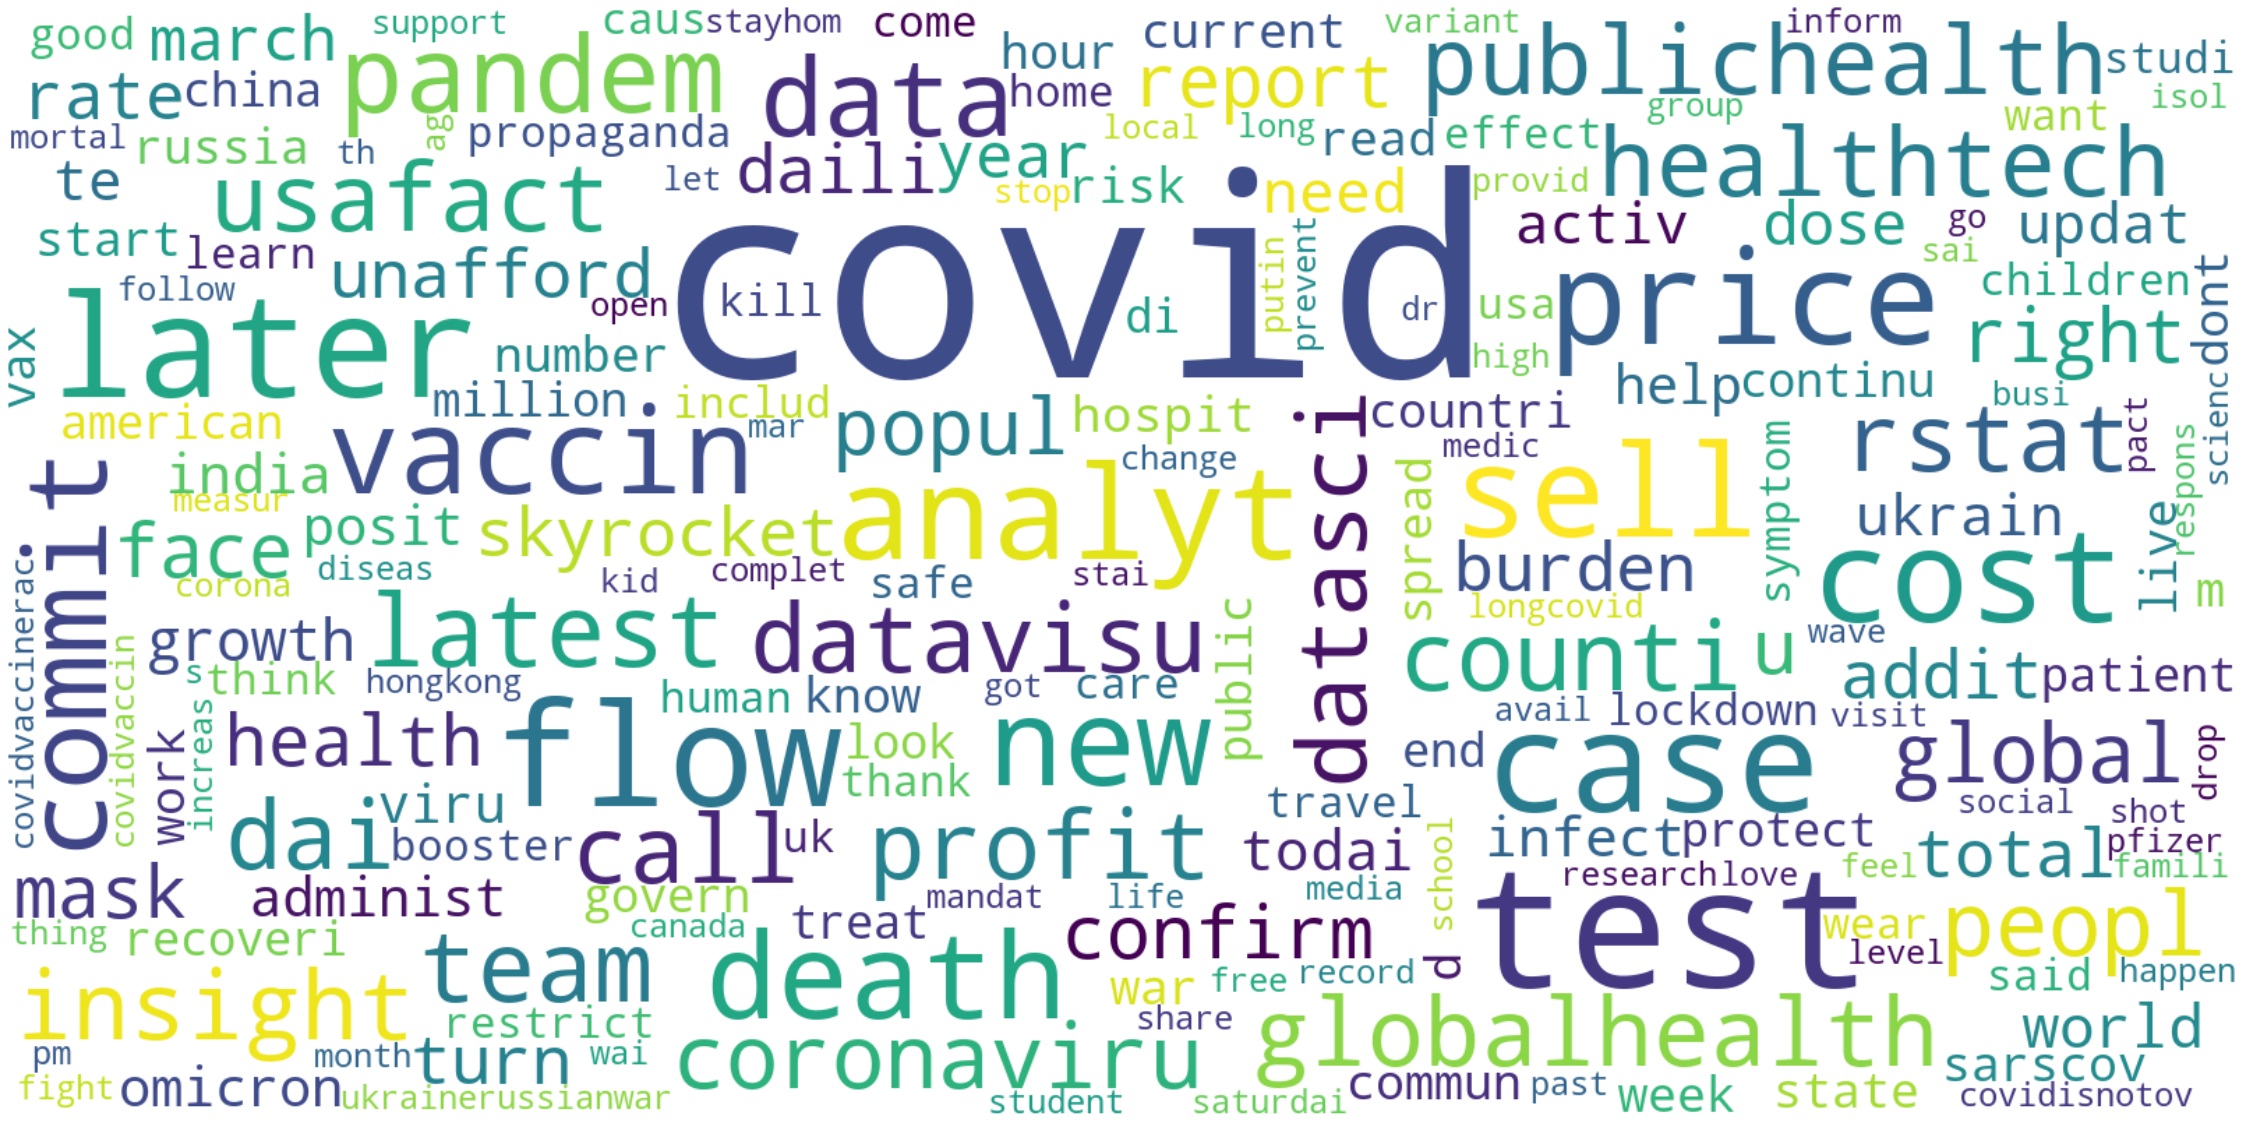

In [47]:
wordcloud = WordCloud(width=1600,height=800,max_font_size=200,max_words=200,collocations=False, background_color='white').generate(string)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Sentiment category

In [48]:
#Calculating Negative, Positive, Neutral and Compound values

nltk.download('vader_lexicon')


data[['polarity', 'subjectivity']] = data['cleantext'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in data['cleantext'].iteritems():
 score = SentimentIntensityAnalyzer().polarity_scores(row)
 neg = score['neg']
 neu = score['neu']
 pos = score['pos']
 comp = score['compound']
 if neg > pos:
  data.loc[index, 'sentiment'] = 'negative'
 elif pos > neg:
  data.loc[index, 'sentiment'] = 'positive'
 else:
  data.loc[index, 'sentiment'] = 'neutral'
 data.loc[index, 'neg'] = neg
 data.loc[index, 'neu'] = neu
 data.loc[index, 'pos'] = pos
 data.loc[index, 'compound'] = comp
data.head(10)


[nltk_data] Downloading package vader_lexicon to C:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


text  \
0  Help slow the spread of #COVID19 and identify ...   
1  COVID-19 kills 201 more Iranians over past 24 ...   
2  It’s Sunday, March 6, 2022 &amp; this is your ...   
3  Current #LongCOVID #Statistics Are Missing the...   
4  With news that @BootsUK is selling lateral flo...   
5  With news that @BootsUK is selling lateral flo...   
6  .@BootsUK @LloydsPharmacy @LidlGB @superdrug w...   
7  As we’re facing rapidly increasing prices and ...   
8  7 Day Covid Growth in Deaths per 1K Population...   
9  With news that @BootsUK is selling lateral flo...   

                                           cleantext  \
0  help slow spread covid identifi risk case soon...   
1      covid kill iranian past hour covid coronaviru   
2  sundai march daili remind told american covid ...   
3  current longcovid statist miss background prev...   
4  new sell later flow test call us later flow te...   
5  new sell later flow test call us later flow te...   
6  commit sell later flow test cost price profit ...   
7  face rapidli increas price addit cost later fl...   
8  dai covid growth death k popul counti ne  late...   
9  new sell later flow test call us later flow te...   

                                              tokens  polarity  subjectivity  \
0  [help, slow, spread, covid, identifi, risk, ca... -0.300000      0.400000   
1  [covid, kill, iranian, past, hour, covid, coro... -0.250000      0.250000   
2  [sundai, march, daili, remind, told, american,...  0.000000      0.000000   
3  [current, longcovid, statist, miss, background...  0.000000      0.400000   
4  [new, sell, later, flow, test, call, us, later...  0.034091      0.113636   
5  [new, sell, later, flow, test, call, us, later...  0.034091      0.113636   
6  [commit, sell, later, flow, test, cost, price,...  0.000000      0.000000   
7  [face, rapidli, increas, price, addit, cost, l...  0.000000      0.000000   
8  [dai, covid, growth, death, k, popul, counti, ...  0.500000      0.900000   
9  [new, sell, later, flow, test, call, us, later...  0.034091      0.113636   

  sentiment    neg    neu    pos  compound  
0  positive  0.125  0.714  0.161    0.1531  
1  negative  0.439  0.561  0.000   -0.6908  
2   neutral  0.000  1.000  0.000    0.0000  
3  negative  0.091  0.909  0.000   -0.1531  
4  positive  0.000  0.779  0.221    0.6249  
5  positive  0.000  0.779  0.221    0.6249  
6  positive  0.000  0.638  0.362    0.6249  
7  negative  0.144  0.746  0.109   -0.1779  
8  negative  0.142  0.764  0.095   -0.3182  
9  positive  0.000  0.779  0.221    0.6249

In [49]:
data[:50]

text  \
0   Help slow the spread of #COVID19 and identify ...   
1   COVID-19 kills 201 more Iranians over past 24 ...   
2   It’s Sunday, March 6, 2022 &amp; this is your ...   
3   Current #LongCOVID #Statistics Are Missing the...   
4   With news that @BootsUK is selling lateral flo...   
5   With news that @BootsUK is selling lateral flo...   
6   .@BootsUK @LloydsPharmacy @LidlGB @superdrug w...   
7   As we’re facing rapidly increasing prices and ...   
8   7 Day Covid Growth in Deaths per 1K Population...   
9   With news that @BootsUK is selling lateral flo...   
10  .@BootsUK @LloydsPharmacy @LidlGB @superdrug w...   
11  #Nagaland #COVID19 #UPDATE as on March 6, 2022...   
12  Right now we’re facing skyrocketing prices and...   
13  The #COVID19 #pandemic of #2020 caused great #...   
14  .@BootsUK @LloydsPharmacy @LidlGB @superdrug w...   
15  Right now we’re facing skyrocketing prices and...   
16  .@BootsUK @LloydsPharmacy @LidlGB @superdrug w...   
17  .@BootsUK @LloydsPharmacy @LidlGB @superdrug w...   
18  7 Day Covid Growth in Deaths per 1K Population...   
19  Right now we’re facing skyrocketing prices and...   
20  Download it:     https://t.co/mUd8hbEHq1\n\n#D...   
21  SOCIAL DISTANCING AND WEARING MASKS OUTDOORS A...   
22  Right now we’re facing skyrocketing prices and...   
23  Just saw a truck say “stay home if you’re sick...   
24  .@JoeBiden Versus the Friends of #COVID19 (by ...   
25  @disclosetv While the natural gas flow from Ru...   
26  China's 'Two Sessions' to build on success aga...   
27  With news that @BootsUK is selling lateral flo...   
28  J&amp;K #COVID19 Update\n\n31 new positive cas...   
29  7 Day Covid Growth in Deaths per 1K Population...   
30  Check out this week’s #NYCTestandTrace #COVID1...   
31  #COVID19 | Faridabad reports 11 new cases, 0 d...   
32  Two years ago is when #COVID19 began to domina...   
33  Call the #brand department-“We Found A Winner”...   
34  .@BootsUK @LloydsPharmacy @LidlGB @superdrug w...   
35  Right now we’re facing skyrocketing prices and...   
36  Bil Jac VetDogs Skin Coat Treats - Treats ==&g...   
37  Right now we’re facing skyrocketing prices and...   
38  .@BootsUK @LloydsPharmacy @LidlGB @superdrug w...   
39  With news that @BootsUK is selling lateral flo...   
40  🛑 Covid Numbers -&gt; % active cases to Hosp r...   
41  @nilikm What about diet &amp; exercise, supple...   
42  With news that @BootsUK is selling lateral flo...   
43  Happy #COVID19 Sunday\n#OregonShelterInPlace D...   
44  #Karnataka government has informed the Supreme...   
45  7 Day Covid Growth in Deaths per 1K Population...   
46  #Facebook now tagging posts that have nothing ...   
47  With news that @BootsUK is selling lateral flo...   
48  Asha Kumari, member of a JEEViKA Self Help Gro...   
49  @Surgeon_General @smithsonian Please focus mor...   

                                            cleantext  \
0   help slow spread covid identifi risk case soon...   
1       covid kill iranian past hour covid coronaviru   
2   sundai march daili remind told american covid ...   
3   current longcovid statist miss background prev...   
4   new sell later flow test call us later flow te...   
5   new sell later flow test call us later flow te...   
6   commit sell later flow test cost price profit ...   
7   face rapidli increas price addit cost later fl...   
8   dai covid growth death k popul counti ne  late...   
9   new sell later flow test call us later flow te...   
10  commit sell later flow test cost price profit ...   
11                         nagaland covid updat march   
12  right face skyrocket price addit cost later fl...   
13  covid pandem caus great travel restrict travel...   
14  commit sell later flow test cost price profit ...   
15  right face skyrocket price addit cost later fl...   
16  commit sell later flow test cost price profit ...   
17  commit sell later flow test cost price profit ...   
18  dai covid growth death k popul counti ne  late...   
1

In [50]:
data_negative = data[data['sentiment']=='negative']
data_positive = data[data['sentiment']=='positive']
data_neutral = data[data['sentiment']=='neutral']

## Sentiment percentile

In [51]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(data,'sentiment')

Total  Percentage
negative   4447       35.71
positive   4442       35.67
neutral    3563       28.61

## Pie chart

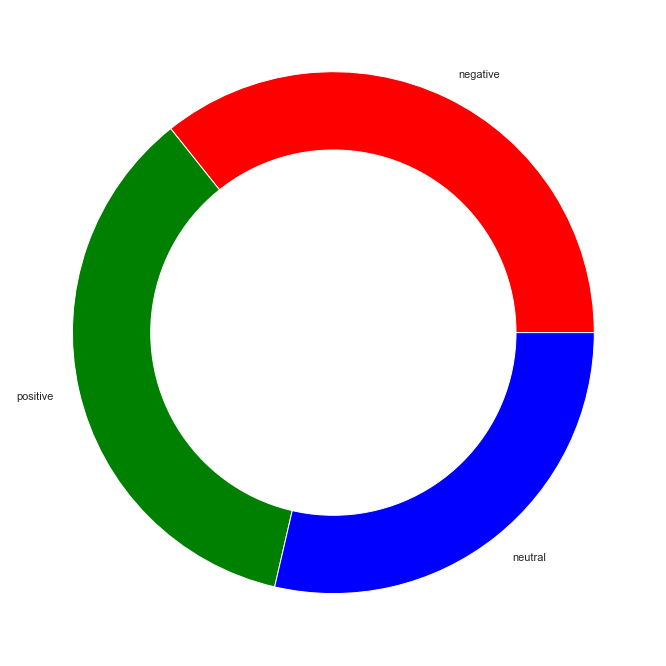

In [52]:
pichart = count_values_in_column(data,'sentiment')
names= pichart.index
size=pichart['Percentage']

 
sns.set(rc={'figure.figsize':(16,12)})
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['red','green','blue'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [53]:
data_negative

text  \
1      COVID-19 kills 201 more Iranians over past 24 ...   
3      Current #LongCOVID #Statistics Are Missing the...   
7      As we’re facing rapidly increasing prices and ...   
8      7 Day Covid Growth in Deaths per 1K Population...   
12     Right now we’re facing skyrocketing prices and...   
...                                                  ...   
12437  The additional #COVID19 deaths bring the total...   
12440  @CIA You're a bunch of treasonous 🐀 for how yo...   
12443  I'm very crashed but feel real actual fatigue ...   
12444  Shane Warne friends battled 20 minutes to save...   
12446  @JBlairlife The #UkraineRussianWar has made pe...   

                                               cleantext  \
1          covid kill iranian past hour covid coronaviru   
3      current longcovid statist miss background prev...   
7      face rapidli increas price addit cost later fl...   
8      dai covid growth death k popul counti ne  late...   
12     right face skyrocket price addit cost later fl...   
...                                                  ...   
12437  addit covid death bring total start pandem typ...   
12440  your bunch treason handl hong kong ccp releas ...   
12443  im crash feel real actual fatigu like normal p...   
12444  shane warn friend battl minut save life stun r...   
12446               ukrainerussianwar peopl forget covid   

                                                  tokens  polarity  \
1      [covid, kill, iranian, past, hour, covid, coro... -0.250000   
3      [current, longcovid, statist, miss, background...  0.000000   
7      [face, rapidli, increas, price, addit, cost, l...  0.000000   
8      [dai, covid, growth, death, k, popul, counti, ...  0.500000   
12     [right, face, skyrocket, price, addit, cost, l...  0.142857   
...                                                  ...       ...   
12437  [addit, covid, death, bring, total, start, pan...  0.050000   
12440  [you'r, bunch, treason, handl, hong, kong, ccp...  0.166667   
12443  [i'm, crash, feel, real, actual, fatigu, like,...  0.075000   
12444  [shane, warn, friend, battl, minut, save, life...  0.000000   
12446          [ukrainerussianwar, peopl, forget, covid]  0.000000   

       subjectivity sentiment    neg    neu    pos  compound  
1          0.250000  negative  0.439  0.561  0.000   -0.6908  
3          0.400000  negative  0.091  0.909  0.000   -0.1531  
7          0.000000  negative  0.144  0.746  0.109   -0.1779  
8          0.900000  negative  0.142  0.764  0.095   -0.3182  
12         0.267857  negative  0.131  0.769  0.100   -0.1779  
...             ...       ...    ...    ...    ...       ...  
12437      0.575000  negative  0.286  0.586  0.128   -0.7430  
12440      0.333333  negative  0.328  0.552  0.120   -0.7783  
12443      0.400000  negative  0.178  0.658  0.164   -0.0516  
12444      0.000000  negative  0.280  0.514  0.206    0.1779  
12446      0.000000  negative  0.388  0.612  0.000   -0.2263  

[4447 rows x 10 columns]

## Positive word cloud

In [54]:
string2 = pd.Series(data_positive['cleantext']).str.cat(sep=' ')

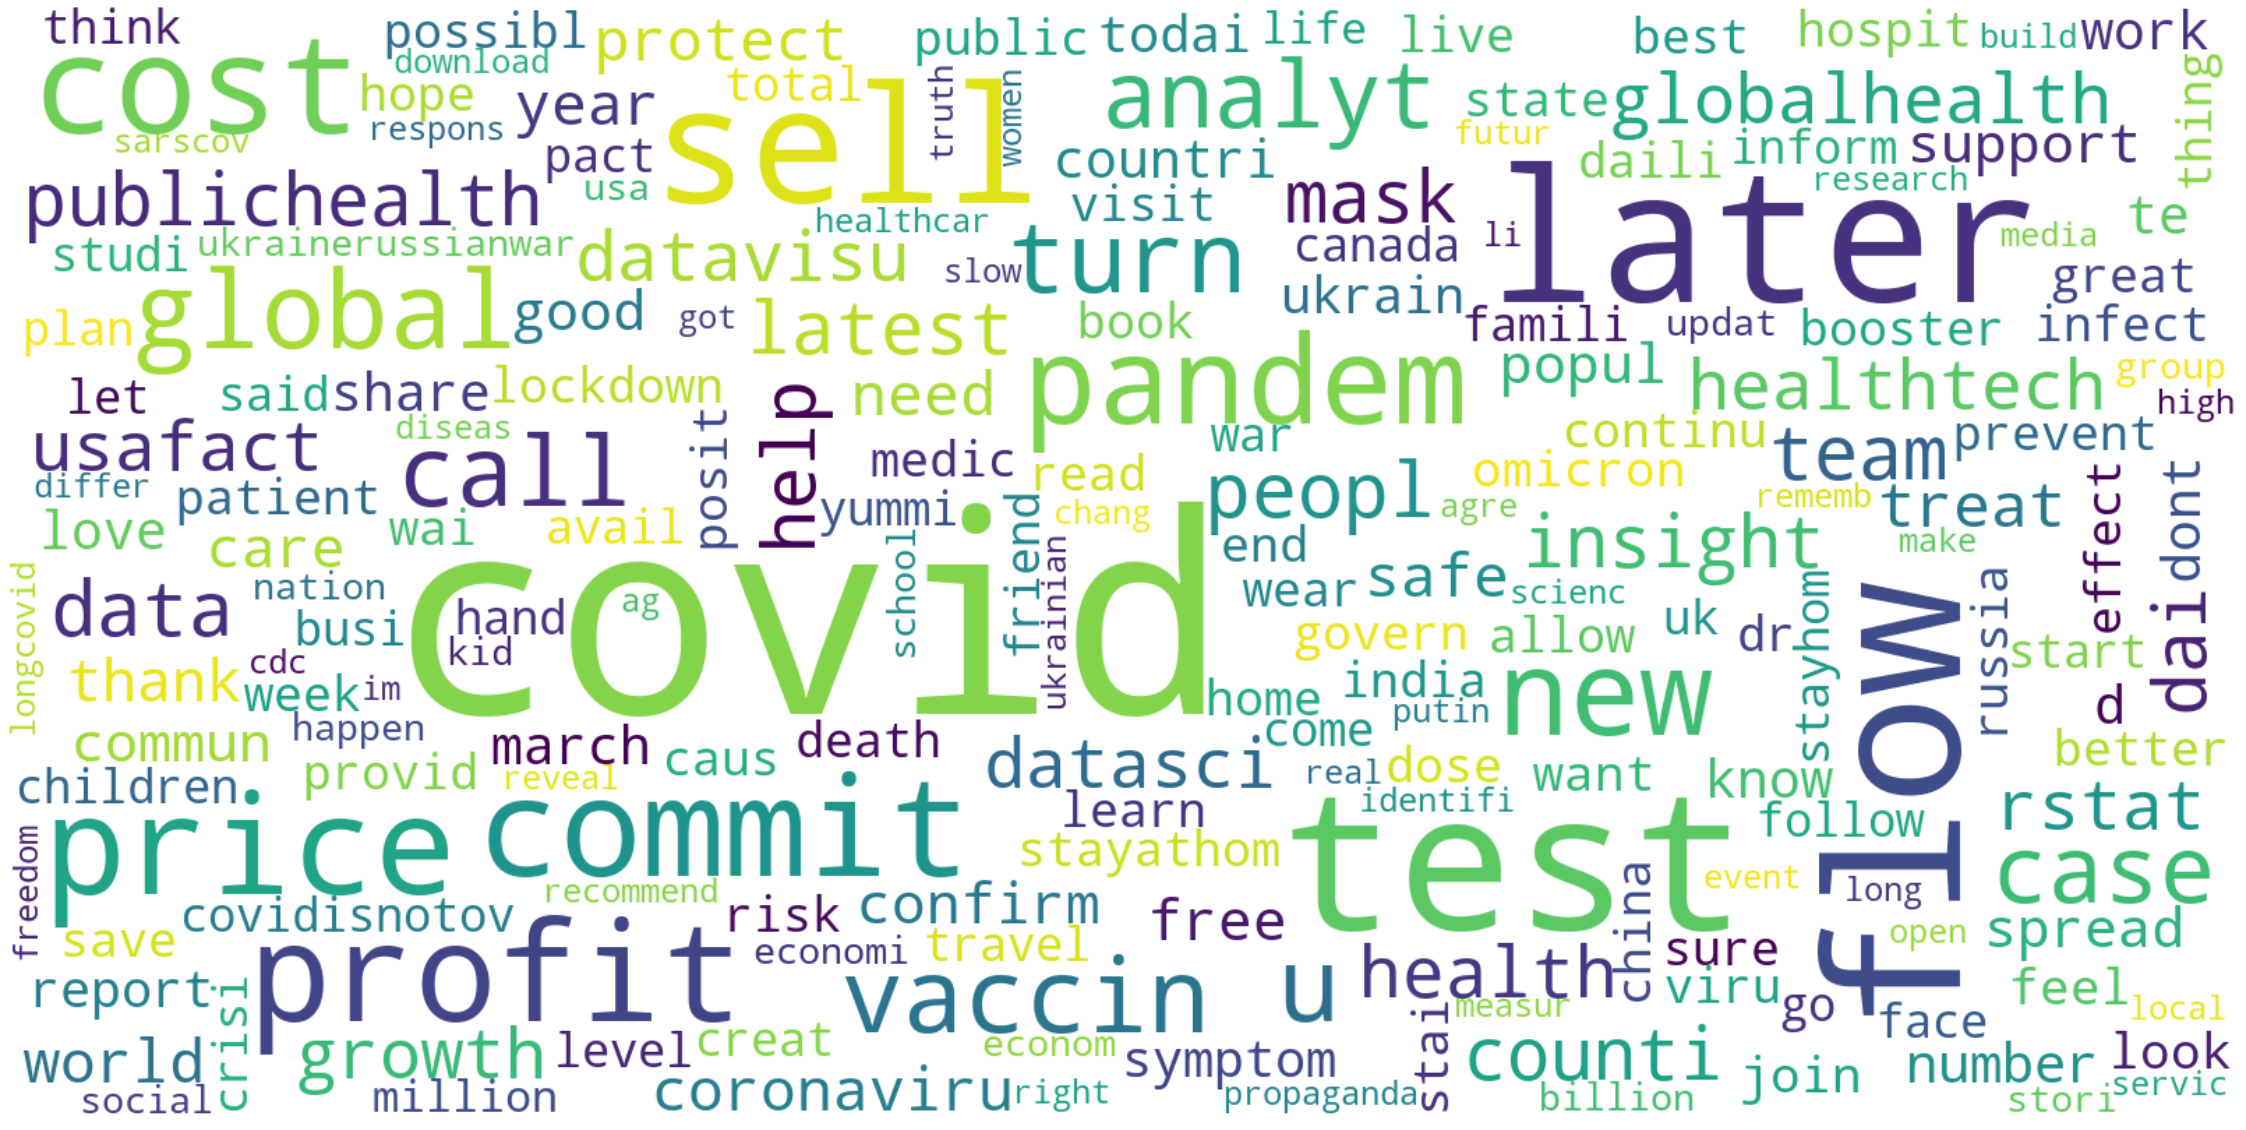

In [55]:
wordcloud = WordCloud(width=1600,height=800,max_font_size=200,max_words=200,collocations=False, background_color='white').generate(string2)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Negative word cloud

In [56]:
string1 = pd.Series(data_negative['cleantext']).str.cat(sep=' ')

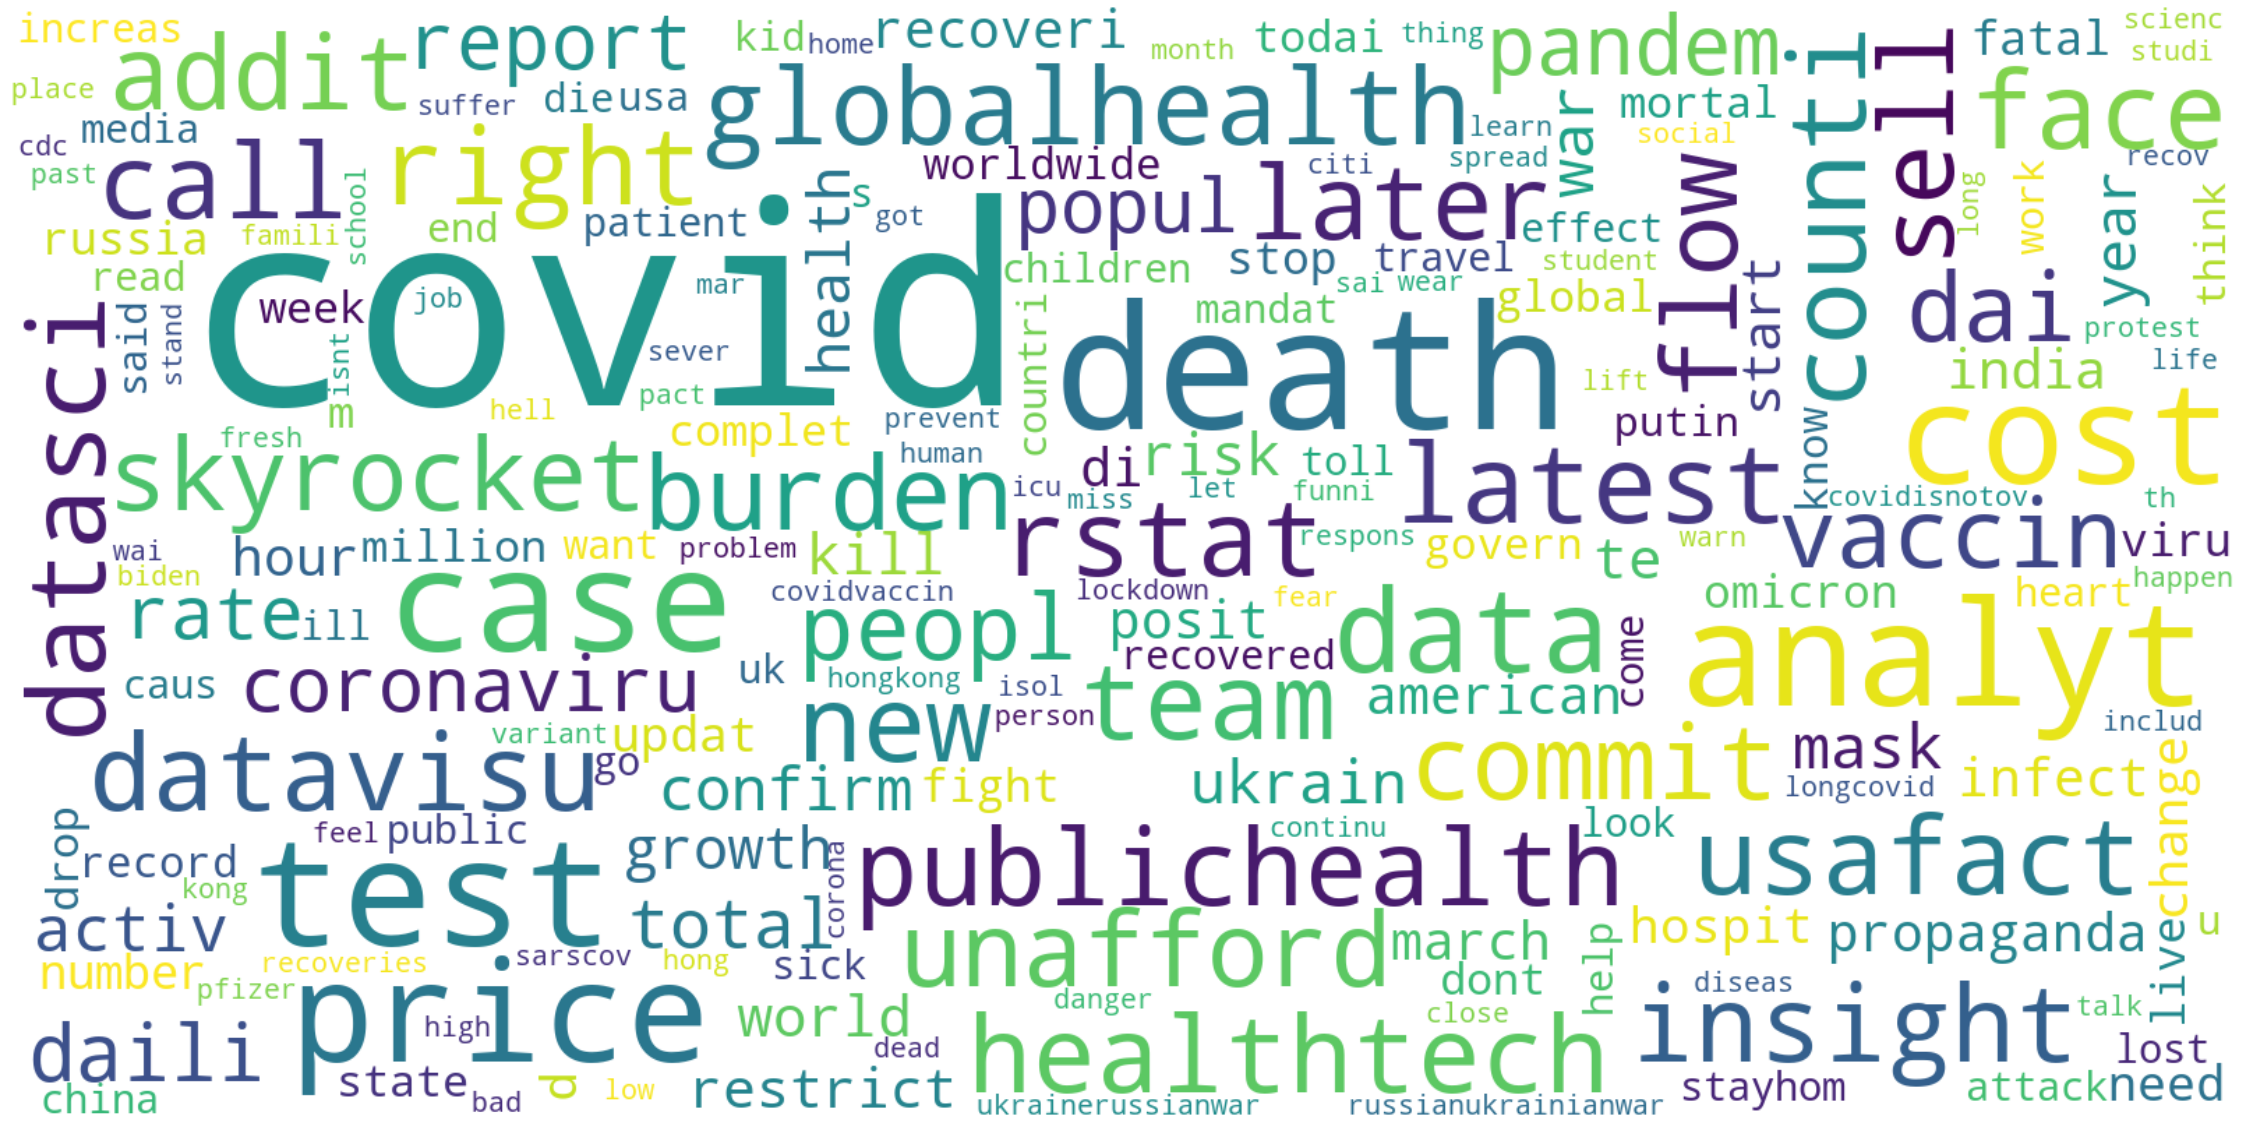

In [57]:
wordcloud = WordCloud(width=1600,height=800,max_font_size=200,max_words=200,collocations=False, background_color='white').generate(string1)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Word density by sentiment

In [58]:
#Calculating tweet’s lenght and word count
data['text_len'] = data['cleantext'].astype(str).apply(len)
data['text_word_count'] =data['cleantext'].apply(lambda x: len(str(x).split()))
round(pd.DataFrame(data.groupby("sentiment").text_len.mean()),2)

text_len
sentiment          
negative     115.35
neutral       96.76
positive     107.80

## Word Count

In [59]:
round(pd.DataFrame(data.groupby('sentiment').text_word_count.mean()),2)

text_word_count
sentiment                 
negative             17.36
neutral              13.75
positive             16.67

In [60]:
data_negative

text  \
1      COVID-19 kills 201 more Iranians over past 24 ...   
3      Current #LongCOVID #Statistics Are Missing the...   
7      As we’re facing rapidly increasing prices and ...   
8      7 Day Covid Growth in Deaths per 1K Population...   
12     Right now we’re facing skyrocketing prices and...   
...                                                  ...   
12437  The additional #COVID19 deaths bring the total...   
12440  @CIA You're a bunch of treasonous 🐀 for how yo...   
12443  I'm very crashed but feel real actual fatigue ...   
12444  Shane Warne friends battled 20 minutes to save...   
12446  @JBlairlife The #UkraineRussianWar has made pe...   

                                               cleantext  \
1          covid kill iranian past hour covid coronaviru   
3      current longcovid statist miss background prev...   
7      face rapidli increas price addit cost later fl...   
8      dai covid growth death k popul counti ne  late...   
12     right face skyrocket price addit cost later fl...   
...                                                  ...   
12437  addit covid death bring total start pandem typ...   
12440  your bunch treason handl hong kong ccp releas ...   
12443  im crash feel real actual fatigu like normal p...   
12444  shane warn friend battl minut save life stun r...   
12446               ukrainerussianwar peopl forget covid   

                                                  tokens  polarity  \
1      [covid, kill, iranian, past, hour, covid, coro... -0.250000   
3      [current, longcovid, statist, miss, background...  0.000000   
7      [face, rapidli, increas, price, addit, cost, l...  0.000000   
8      [dai, covid, growth, death, k, popul, counti, ...  0.500000   
12     [right, face, skyrocket, price, addit, cost, l...  0.142857   
...                                                  ...       ...   
12437  [addit, covid, death, bring, total, start, pan...  0.050000   
12440  [you'r, bunch, treason, handl, hong, kong, ccp...  0.166667   
12443  [i'm, crash, feel, real, actual, fatigu, like,...  0.075000   
12444  [shane, warn, friend, battl, minut, save, life...  0.000000   
12446          [ukrainerussianwar, peopl, forget, covid]  0.000000   

       subjectivity sentiment    neg    neu    pos  compound  
1          0.250000  negative  0.439  0.561  0.000   -0.6908  
3          0.400000  negative  0.091  0.909  0.000   -0.1531  
7          0.000000  negative  0.144  0.746  0.109   -0.1779  
8          0.900000  negative  0.142  0.764  0.095   -0.3182  
12         0.267857  negative  0.131  0.769  0.100   -0.1779  
...             ...       ...    ...    ...    ...       ...  
12437      0.575000  negative  0.286  0.586  0.128   -0.7430  
12440      0.333333  negative  0.328  0.552  0.120   -0.7783  
12443      0.400000  negative  0.178  0.658  0.164   -0.0516  
12444      0.000000  negative  0.280  0.514  0.206    0.1779  
12446      0.000000  negative  0.388  0.612  0.000   -0.2263  

[4447 rows x 10 columns]

In [63]:
data_negative.to_csv('negativetext.csv',index=False)

In [61]:
data_positive

text  \
0      Help slow the spread of #COVID19 and identify ...   
4      With news that @BootsUK is selling lateral flo...   
5      With news that @BootsUK is selling lateral flo...   
6      .@BootsUK @LloydsPharmacy @LidlGB @superdrug w...   
9      With news that @BootsUK is selling lateral flo...   
...                                                  ...   
12445  Cloth masks not much help for viral particles ...   
12447  Here are 5 things to know about @CDCgov 's new...   
12449  Use your brain. If I go to the masked cashier ...   
12450  Nothing to see here folks, just the Australian...   
12451  COVID19 - Studies about the bond between pets ...   

                                               cleantext  \
0      help slow spread covid identifi risk case soon...   
4      new sell later flow test call us later flow te...   
5      new sell later flow test call us later flow te...   
6      commit sell later flow test cost price profit ...   
9      new sell later flow test call us later flow te...   
...                                                  ...   
12445  cloth mask help viral particl  studi covid cdn...   
12447  thing know s new covid commun level find commu...   
12449  us brain mask cashier mask wait mask cashier d...   
12450  folk australian health offici admit vaccin dy ...   
12451  covid  studi bond pet human popular pandem dog...   

                                                  tokens  polarity  \
0      [help, slow, spread, covid, identifi, risk, ca... -0.300000   
4      [new, sell, later, flow, test, call, us, later...  0.034091   
5      [new, sell, later, flow, test, call, us, later...  0.034091   
6      [commit, sell, later, flow, test, cost, price,...  0.000000   
9      [new, sell, later, flow, test, call, us, later...  0.034091   
...                                                  ...       ...   
12445  [cloth, mask, help, viral, particl, studi, cov...  0.000000   
12447  [thing, know, s, new, covid, commun, level, fi...  0.136364   
12449  [us, brain, mask, cashier, mask, wait, mask, c... -0.800000   
12450  [folk, australian, health, offici, admit, vacc...  0.000000   
12451  [covid, studi, bond, pet, human, popular, pand...  0.300000   

       subjectivity sentiment    neg    neu    pos  compound  
0          0.400000  positive  0.125  0.714  0.161    0.1531  
4          0.113636  positive  0.000  0.779  0.221    0.6249  
5          0.113636  positive  0.000  0.779  0.221    0.6249  
6          0.000000  positive  0.000  0.638  0.362    0.6249  
9          0.113636  positive  0.000  0.779  0.221    0.6249  
...             ...       ...    ...    ...    ...       ...  
12445      0.000000  positive  0.000  0.722  0.278    0.4019  
12447      0.454545  positive  0.000  0.701  0.299    0.6597  
12449      1.000000  positive  0.000  0.812  0.188    0.4168  
12450      0.000000  positive  0.000  0.847  0.153    0.2023  
12451      0.500000  positive  0.000  0.757  0.243    0.5423  

[4442 rows x 10 columns]

In [64]:
data_positive.to_csv('positivetext.csv',index=False)

In [62]:
data_neutral

text  \
2      It’s Sunday, March 6, 2022 &amp; this is your ...   
11     #Nagaland #COVID19 #UPDATE as on March 6, 2022...   
20     Download it:     https://t.co/mUd8hbEHq1\n\n#D...   
21     SOCIAL DISTANCING AND WEARING MASKS OUTDOORS A...   
30     Check out this week’s #NYCTestandTrace #COVID1...   
...                                                  ...   
12427  What have we learnt entering the 3rd year of #...   
12429  A ton of #covid19 data incoming.\n\nHere is is...   
12435  Is this finally the end to the #COVID19 emerge...   
12439  Happy #COVID19 Friday\n#OregonShelterInPlace D...   
12448  How's it going?  #COVID19 #photography https:/...   

                                               cleantext  \
2      sundai march daili remind told american covid ...   
11                            nagaland covid updat march   
20     download it datasci python daysofcod iot flutt...   
21     social distanc wear mask outdoor longer mandat...   
30     check week nyctestandtrac covid test site onst...   
...                                                  ...   
12427  learnt enter rd year covid prepar pandem new s...   
12429  ton covid data incom scrape az dashboard   pos...   
12435             final end covid emerg kansa senat tell   
12439  happi covid fridai oregonshelterinplac dai now...   
12448                           how go covid photographi   

                                                  tokens  polarity  \
2      [sundai, march, daili, remind, told, american,...  0.000000   
11                       [nagaland, covid, updat, march]  0.000000   
20     [download, datasci, python, daysofcod, iot, fl...  0.000000   
21     [social, distanc, wear, mask, outdoor, longer,...  0.033333   
30     [check, week, nyctestandtrac, covid, test, sit...  0.000000   
...                                                  ...       ...   
12427  [learnt, enter, rd, year, covid, prepar, pande...  0.136364   
12429  [ton, covid, data, incom, scrape, az', dashboa...  0.000000   
12435     [final, end, covid, emerg, kansa, senat, tell]  0.000000   
12439  [happi, covid, fridai, oregonshelterinplac, da...  0.000000   
12448                     [how', go, covid, photographi]  0.000000   

       subjectivity sentiment  neg  neu  pos  compound  
2          0.000000   neutral  0.0  1.0  0.0       0.0  
11         0.000000   neutral  0.0  1.0  0.0       0.0  
20         0.000000   neutral  0.0  1.0  0.0       0.0  
21         0.066667   neutral  0.0  1.0  0.0       0.0  
30         0.000000   neutral  0.0  1.0  0.0       0.0  
...             ...       ...  ...  ...  ...       ...  
12427      0.454545   neutral  0.0  1.0  0.0       0.0  
12429      0.000000   neutral  0.0  1.0  0.0       0.0  
12435      1.000000   neutral  0.0  1.0  0.0       0.0  
12439      0.000000   neutral  0.0  1.0  0.0       0.0  
12448      0.000000   neutral  0.0  1.0  0.0       0.0  

[3563 rows x 10 columns]

In [65]:
data_neutral.to_csv('neutraltext.csv',index=False)